In [73]:
data_folder='/fs/scratch/PCON0023/split/experiment_2/train'

In [74]:
from helper_code import *

In [75]:
import numpy as np, os, sys

import mne
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import joblib

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [76]:
patient_ids = find_data_folders(data_folder)
num_patients = len(patient_ids)

In [77]:
num_patients

486

In [78]:
eeg_features = list()
ecg_features = list()
clinical_features = list()
outcomes = list()
cpcs = list()

In [79]:
eeg_requested_channels=['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

In [80]:
ecg_requested_channels = ['ECG', 'ECGL', 'ECGR', 'ECG1', 'ECG2']

In [81]:
def preprocess_data(data, sampling_frequency, utility_frequency):
    # Define the bandpass frequencies.
    passband = [0.1, 30.0]

    # Promote the data to double precision because these libraries expect double precision.
    data = np.asarray(data, dtype=np.float64)

    # If the utility frequency is between bandpass frequencies, then apply a notch filter.
    if utility_frequency is not None and passband[0] <= utility_frequency <= passband[1]:
        data = mne.filter.notch_filter(data, sampling_frequency, utility_frequency, n_jobs=4, verbose='error')

    # Apply a bandpass filter.
    data = mne.filter.filter_data(data, sampling_frequency, passband[0], passband[1], n_jobs=4, verbose='error')

    # Resample the data.
    if sampling_frequency % 2 == 0:
        resampling_frequency = 128
    else:
        resampling_frequency = 125
    lcm = np.lcm(int(round(sampling_frequency)), int(round(resampling_frequency)))
    up = int(round(lcm / sampling_frequency))
    down = int(round(lcm / resampling_frequency))
    resampling_frequency = sampling_frequency * up / down
    data = scipy.signal.resample_poly(data, up, down, axis=1)

    # Scale the data to the interval [-1, 1].
    min_value = np.min(data)
    max_value = np.max(data)
    if min_value != max_value:
        data = 2.0 / (max_value - min_value) * (data - 0.5 * (min_value + max_value))
    else:
        data = 0 * data

    return data, resampling_frequency

In [82]:
def get_patient_features(data):
    age = get_age(data)
    sex = get_sex(data)
    rosc = get_rosc(data)
    ohca = get_ohca(data)
    shockable_rhythm = get_shockable_rhythm(data)
    ttm = get_ttm(data)

    sex_features = np.zeros(2, dtype=int)
    if sex == 'Female':
        female = 1
        male   = 0
        other  = 0
    elif sex == 'Male':
        female = 0
        male   = 1
        other  = 0
    else:
        female = 0
        male   = 0
        other  = 1

    features = np.array((age, female, male, other, rosc, ohca, shockable_rhythm, ttm))

    return features

In [83]:
for i in range(num_patients):
    recording_ids = find_recording_files(data_folder, patient_ids[i])
    num_recordings = len(recording_ids)
    
    recording_id = recording_ids[0]
    group="ECG"
    recording_location = os.path.join(data_folder, patient_ids[i], '{}_{}'.format(recording_id, group))
    
    if os.path.exists(recording_location + '.hea'):
            data, channels, sampling_frequency = load_recording_data(recording_location)
            utility_frequency = get_utility_frequency(recording_location + '.hea')
            data, channels = reduce_channels(data, channels, ecg_requested_channels)
            data, sampling_frequency = preprocess_data(data, sampling_frequency, utility_frequency)
            data=expand_channels(data, channels, ecg_requested_channels)

            if len(data[0])<10000:
                mean = np.mean(data, axis=1, keepdims=True)  
                missing_length = 10000 - data.shape[1]
                missing_elements = np.full((data.shape[0], missing_length), mean)  
                data = np.concatenate((data, missing_elements), axis=1)  
                ecg_features.append(data)
                print('ecg_features',data)
                print('ecg_shape',data.shape)
            else:
                data=data[:,:10000]
                ecg_features.append(data)
                print('ecg_features',data)
                print(type(ecg_features))
                print('ecg_shape',data.shape)

    else:
        data=np.full((5, 10000), np.nan)
        ecg_features.append(data)
        print('ecg_features',data)
        print('ecg_shape',data.shape)
        
        
    recording_id = recording_ids[-1]
    group="EEG"
    recording_location = os.path.join(data_folder, patient_ids[i], '{}_{}'.format(recording_id, group))
    
    if os.path.exists(recording_location + '.hea'):
            data, channels, sampling_frequency = load_recording_data(recording_location)
            data,channels=reduce_channels(data,channels,eeg_requested_channels)
            utility_frequency = get_utility_frequency(recording_location + '.hea')
            data, sampling_frequency = preprocess_data(data, sampling_frequency, utility_frequency)
            
            if len(data[0])<10000:
                
                mean = np.mean(data, axis=1, keepdims=True) 
                missing_length = 10000 - data.shape[1]
                missing_elements = np.full((data.shape[0], missing_length), mean)  
                data = np.concatenate((data, missing_elements), axis=1)  
                eeg_features.append(data)
                print('eeg_features',data)
                print('eeg_shape',data.shape)
                
            else:
                data=data[:,-10000:]
                eeg_features.append(data)
                print('eeg_features',data)
                print('eeg_shape',data.shape)

    else:
        data=np.full((19, 10000), np.nan)
        eeg_features.append(data)
        print('eeg_features',data)
        print('eeg_shape',data.shape)
    
    patient_metadata = load_challenge_data(data_folder, patient_ids[i])
    patient_features = get_patient_features(patient_metadata)
    clinical_features.append(patient_features)
    print('clinical features',patient_features)
    print('clinical shape',patient_features.shape)
    current_outcome = get_outcome(patient_metadata)
    outcomes.append(current_outcome)
    current_cpc = get_cpc(patient_metadata)
    cpcs.append(current_cpc)
        
eeg_features = np.stack(eeg_features,axis=0)
ecg_features = np.stack(ecg_features,axis=0)
clinical_features = np.vstack(clinical_features)
outcomes = np.vstack(outcomes)
cpcs = np.vstack(cpcs)
print(eeg_features.shape)
print(ecg_features.shape)
print(clinical_features.shape)
eeg_features = np.nan_to_num(eeg_features)
ecg_features = np.nan_to_num(ecg_features)




ecg_features [[-0.03450747 -0.03614919 -0.03615916 ... -0.35312596 -0.35613619
  -0.36151448]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]
<class 'list'>
ecg_shape (5, 10000)
eeg_features [[-0.06645027 -0.06575771 -0.06395021 ... -0.04650431 -0.04650267
  -0.04650107]
 [-0.06642156 -0.06542973 -0.06304596 ... -0.04651014 -0.04650642
  -0.04650258]
 [-0.05920808 -0.05931511 -0.05863642 ... -0.04649744 -0.04649828
  -0.04649927]
 ...
 [-0.05669905 -0.05602289 -0.05459585 ... -0.04649618 -0.04649745
  -0.04649896]
 [-0.04461702 -0.04364146 -0.04302087 ... -0.04649226 -0.04649496
  -0.04649791]
 [-0.037625   -0.03759019 -0.0381069  ... -0.04650677 -0.0465043
  -0.04650167]]
eeg_shape (19, 10000)
clinical features [

In [84]:
imputer = SimpleImputer().fit(clinical_features)
clinical_features = imputer.transform(clinical_features)

In [85]:
class BinaryClassifier(nn.Module):
    def __init__(self, num_channels):
        super(BinaryClassifier, self).__init__()
        self.num_channels = num_channels
        
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=100, stride=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=100, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=100, stride=2)
        self.fc1 = nn.Linear(64 * 533, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)


    def forward(self, x):
        #print("Input shape:", x.shape)
        x = self.conv1(x)
        #print("conv1", x.shape)
        x = self.relu(x)
        
        x = self.pool(x)
        
        #print("pool1", x.shape)
        
        x = self.conv2(x)
        #print("conv2", x.shape)
        x = self.relu(x)
        
        x = self.pool(x)
       # print("pool2", x.shape)
        x = x.view(x.size(0), -1)
        #print("before fc", x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        
       # print("after fc1", x.shape)
        x = self.fc2(x)
        x = self.relu(x)
 

        x = self.fc3(x)
        x = self.relu(x)
        #print("After fc3:", x.shape)
        x = self.fc4(x)
        x = self.relu(x)

        
        return x

In [86]:
class MultimodalClassifier(nn.Module):
    def __init__(self, num_eeg_channels, num_ecg_channels, num_clinical_features):
        super(MultimodalClassifier, self).__init__()
        self.eeg_model = BinaryClassifier(num_channels=num_eeg_channels)
        self.ecg_model = BinaryClassifier(num_channels=num_ecg_channels)
        self.num_clinical_features = num_clinical_features

        self.fc_clinical = nn.Linear(num_clinical_features, 32)
        self.relu = nn.ReLU()
        self.fc_final1 = nn.Linear(32+32+32, 24)
        self.fc_final2 = nn.Linear(24, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, eeg_input, ecg_input, clinical_input):
    
        eeg_output = self.eeg_model(eeg_input)

        ecg_output = self.ecg_model(ecg_input)
    

        clinical_output = self.fc_clinical(clinical_input)
        clinical_output = nn.ReLU()(clinical_output)



        concatenated_input = torch.cat((eeg_output, ecg_output, clinical_output), dim=1)


        # Final classification
        final_output = self.fc_final1(concatenated_input)
        final_output=self.relu(final_output)
        final_output=self.fc_final2(final_output)
        final_output = self.sigmoid(final_output)

        return final_output

In [87]:
num_eeg_channels = 19
num_ecg_channels = 5
num_clinical_features = 8

model = MultimodalClassifier(num_eeg_channels, num_ecg_channels, num_clinical_features)

In [88]:
model

MultimodalClassifier(
  (eeg_model): BinaryClassifier(
    (conv1): Conv1d(19, 32, kernel_size=(100,), stride=(2,))
    (relu): ReLU()
    (pool): MaxPool1d(kernel_size=100, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 64, kernel_size=(100,), stride=(2,))
    (fc1): Linear(in_features=34112, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=32, bias=True)
  )
  (ecg_model): BinaryClassifier(
    (conv1): Conv1d(5, 32, kernel_size=(100,), stride=(2,))
    (relu): ReLU()
    (pool): MaxPool1d(kernel_size=100, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 64, kernel_size=(100,), stride=(2,))
    (fc1): Linear(in_features=34112, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=64, bias=True)
 

In [89]:
eeg_data=torch.from_numpy(eeg_features).float()
ecg_data=torch.from_numpy(ecg_features).float()
clinical_data=torch.from_numpy(clinical_features).float()

target=torch.from_numpy(outcomes)
    
    

In [90]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

dataset = TensorDataset(eeg_data, ecg_data, clinical_data, target)

  
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size


train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])
    
batch_size = 64  # Adjust the batch size as per your needs
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve


In [92]:
model.train()
num_epochs = 100
best_val_loss = float('inf')

train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_tprs = []
train_fprs = []
train_aurocs = []
train_aurpcs = []

val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_tprs = []
val_fprs = []
val_aurocs = []
val_aurpcs = []


for epoch in range(num_epochs):
        train_loss = 0.0
        #train_accuracy = 0.0
        
        train_pred_labels = []
        train_true_labels = []
        val_pred_labels = []
        val_true_labels = []
        

        # Iterate over the batches of training data
        for i, (train_eeg_input,train_ecg_input,train_clinical_input, train_target) in enumerate(train_loader):
            


            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            train_output = model(train_eeg_input,train_ecg_input,train_clinical_input)

            # Calculate the loss
            loss = criterion(train_output, train_target.float())

            # Backward pass
            loss.backward()

            # Update the model parameters
            optimizer.step()

            # Accumulate the training loss
            train_loss += loss.item()


            # Calculate accuracy (training)
            train_predicted_labels = (train_output > 0.5).float()
            
            train_pred_labels.extend(train_predicted_labels.cpu().numpy())
            train_true_labels.extend(train_target.cpu().numpy())
            #train_accuracy += (train_predicted_labels == train_target).float().mean()



        train_loss /= len(train_loader)
        #train_accuracy /= len(train_loader)

        # Validation
        val_loss = 0.0
        #val_accuracy = 0.0
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            for val_eeg_input,val_ecg_input,val_clinical_input, val_target in val_loader:
                val_output = model(val_eeg_input,val_ecg_input,val_clinical_input)
                val_loss += criterion(val_output, val_target.float()).item()
                val_predicted_labels = (val_output > 0.5).float()
                
                val_pred_labels.extend(val_predicted_labels.cpu().numpy())
                val_true_labels.extend(val_target.cpu().numpy())
                
                #val_accuracy += (val_predicted_labels == val_target).float().mean()

            val_loss /= len(val_loader)
            #val_accuracy /= len(val_loader)

        
        
        train_pred_labels = np.array(train_pred_labels)
        train_true_labels = np.array(train_true_labels)
        val_pred_labels = np.array(val_pred_labels)
        val_true_labels = np.array(val_true_labels)
        print(train_pred_labels)
        print(train_true_labels)
        print(val_pred_labels)
        print(val_true_labels)

        train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
        train_precision = precision_score(train_true_labels, train_pred_labels)
        train_recall = recall_score(train_true_labels, train_pred_labels)
        train_tpr = train_recall
        train_fpr = 1.0 - train_tpr
        #train_auroc = roc_auc_score(train_true_labels, train_pred_labels)
        train_aurpc = average_precision_score(train_true_labels, train_pred_labels)
        
        if len(np.unique(train_pred_labels)) > 1:
            train_auroc = roc_auc_score(train_true_labels, train_pred_labels)
        else:
            train_auroc=0
            


        val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
        val_precision = precision_score(val_true_labels, val_pred_labels)
        val_recall = recall_score(val_true_labels, val_pred_labels)
        val_tpr = val_recall
        val_fpr = 1.0 - val_tpr
        #val_auroc = roc_auc_score(val_true_labels, val_pred_labels)
        val_aurpc = average_precision_score(val_true_labels, val_pred_labels)
        
        if len(np.unique(val_pred_labels)) > 1:
            val_auroc = roc_auc_score(val_true_labels, val_pred_labels)
        else:
            val_auroc=0       

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_tprs.append(train_tpr)
        train_fprs.append(train_fpr)
        train_aurocs.append(train_auroc)
        train_aurpcs.append(train_aurpc)

 
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_tprs.append(val_tpr)
        val_fprs.append(val_fpr)
        val_aurocs.append(val_auroc)
        val_aurpcs.append(val_aurpc)


        # Print the evaluation metrics for every epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Train Acc: {train_accuracy}, Train Precision: {train_precision}, Train Recall: {train_recall}, Train TPR: {train_tpr}, Train FPR: {train_fpr}, Train AUROC: {train_auroc}, Train AURPC: {train_aurpc}")
        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss}, Val Acc: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val TPR: {val_tpr}, Val FPR: {val_fpr}, Val AUROC: {val_auroc}, Val AURPC: {val_aurpc}")


        # Print the loss and accuracy for every epoch
        #print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Train Acc: {train_accuracy}, Val Loss: {val_loss}, Val Acc: {val_accuracy}")
        
epochs = list(range(1, num_epochs + 1))

plt.figure()
plt.plot(epochs, train_losses, label='Train loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()
plt.savefig('/fs/ess/PCON0023/rahul/plots/loss.png')

plt.figure()
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.savefig('/fs/ess/PCON0023/rahul/plots/accuracy.png')

plt.figure()
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.savefig('/fs/ess/PCON0023/rahul/plots/precision.png')

plt.figure()
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()
plt.savefig('/fs/ess/PCON0023/rahul/plots/recall.png')

plt.figure()
plt.plot(epochs, train_aurocs, label='Train AUROC')
plt.plot(epochs, val_aurocs, label='Validation AUROC')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.title('AUROC')
plt.legend()
plt.savefig('/fs/ess/PCON0023/rahul/plots/auroc.png')

plt.figure()
plt.plot(epochs, train_aurpcs, label='Train AURPC')
plt.plot(epochs, val_aurpcs, label='Validation AURPC')
plt.xlabel('Epoch')
plt.ylabel('AURPC')
plt.title('AURPC')
plt.legend()
plt.savefig('/fs/ess/PCON0023/rahul/plots/aurpc.png')

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

NameError: name 'train_accs' is not defined

<Figure size 432x288 with 0 Axes>

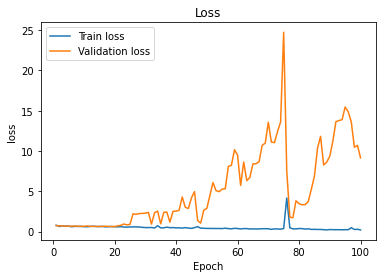

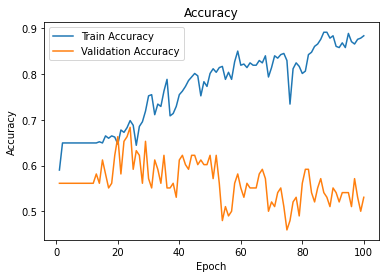

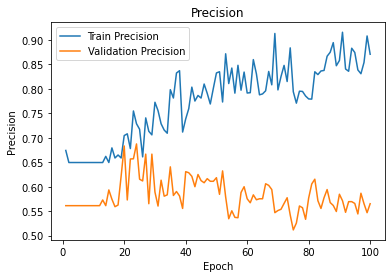

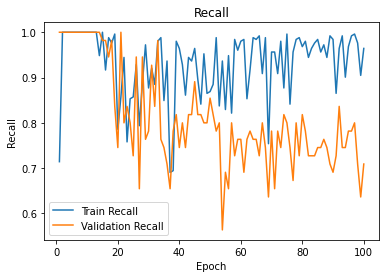

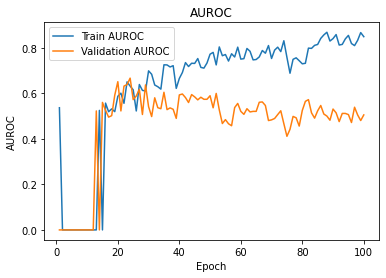

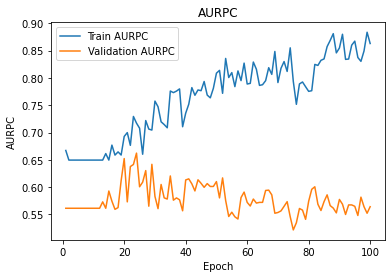

In [93]:
epochs = list(range(1, num_epochs + 1))

plt.figure()
plt.plot(epochs, train_losses, label='Train loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()
plt.savefig('/fs/ess/PCON0023/rahul/plots/loss.png')

plt.figure()
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.savefig('/fs/ess/PCON0023/rahul/plots/accuracy.png')

plt.figure()
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.savefig('/fs/ess/PCON0023/rahul/plots/precision.png')

plt.figure()
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()
plt.savefig('/fs/ess/PCON0023/rahul/plots/recall.png')

plt.figure()
plt.plot(epochs, train_aurocs, label='Train AUROC')
plt.plot(epochs, val_aurocs, label='Validation AUROC')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.title('AUROC')
plt.legend()
plt.savefig('/fs/ess/PCON0023/rahul/plots/auroc.png')

plt.figure()
plt.plot(epochs, train_aurpcs, label='Train AURPC')
plt.plot(epochs, val_aurpcs, label='Validation AURPC')
plt.xlabel('Epoch')
plt.ylabel('AURPC')
plt.title('AURPC')
plt.legend()
plt.savefig('/fs/ess/PCON0023/rahul/plots/aurpc.png')

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epoch=10
for epoch in range(num_epoch):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(eeg_train_data, ecg_train_data, clinical_train_data)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print the loss for monitoring
    print(f"Epoch {epoch+1}: Loss = {loss.item()}")

# After training, you can use the model for predictions
eeg_test_data = torch.randn(10, num_eeg_channels, 30000)
ecg_test_data = torch.randn(10, num_ecg_channels, 30000)
clinical_test_data = torch.randn(10, num_clinical_features, 1)

predictions = model(eeg_test_data, ecg_test_data, clinical_test_data)
print("Predictions:", predictions)